In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.models as models
import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision.transforms import v2
import os
import time
from torchvision.io import read_image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Globals

In [2]:
USE_GPU = True
dtype = torch.float32
print_every = 1000
image_dim = 512

device = 'cuda' if (USE_GPU and torch.cuda.is_available()) else 'cpu'
print("Using:", device)

Using: cuda


# Utils

In [3]:
#Don't need to run this unless you are computing for a new dataset

def calc_mean_std(loader):
    '''
    Calculates the Mean and Std of image dataset for each input channel.

    Assumptions: The dataset has not been Transformed in any way
    other than torchvision.transforms.ToTensor()

    Input: Dataloader using minibatches of shape N x C x H x W

    Output: Two C-vectors indicating mean and std
    '''
    avg = 0
    var = 0
    for e in range(1): #only 1 epoch
        #for t, (x, y) in enumerate(loader):
        for t, x in enumerate(loader):
            # t = batch number (ex. 0-999 for N = 50,000 and loader batch_size = 50)
            # x = 4D tensor batch data (N x C x H x W)
            # y = labels/target for batch
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            #y = y.to(device=device, dtype=torch.long)

            this_avg = torch.mean(x, dim=(0,2,3))
            if t == 0:
                avg = this_avg
            else:
                avg = (t/(t+1))*avg + (1/(t+1))*this_avg

    avg_broad = avg.reshape((1,3,1,1))
    for e in range(1):
        #for t, (x, y) in enumerate(loader):
        for t, x in enumerate(loader):
            x = x.to(device=device, dtype=dtype)
            zero_mean = x - avg_broad
            this_var = torch.mean(torch.mul(zero_mean, zero_mean), dim=(0,2,3))
            if t == 0:
                var = this_var
            else:
                var = (t/(t+1))*var + (1/(t+1))*this_var


    return avg, torch.sqrt(var)

#cifar100_mean, cifar100_std = calc_mean_std(loader_sandbox)
#print("Mean: " + str(cifar100_mean))
#print("Std: " + str(cifar100_std))

# Data

## Transforms

In [4]:
class DilationTransform(nn.Module):
    def __init__(self, min_kernel, max_kernel) -> None:
        super().__init__()
        self.min_kernel = min_kernel
        self.max_kernel = max_kernel

    def forward(self, input):
        kernel_size = torch.randint(self.min_kernel, self.max_kernel, size=(1,1)).item()
        # print(kernel_size)
        N, C, H, W = input.shape
        kernel = torch.ones((C, C, kernel_size, kernel_size))
        out = F.conv2d(input=input, weight=kernel, padding=kernel_size//2, groups=C)
        out = torch.clamp(out, 0, 1)
        return out

In [5]:
class InvertMaskTransform(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mask):
        return 1 - mask

In [59]:
mask_transforms = v2.Compose([
    InvertMaskTransform(),
    DilationTransform(7, 45),
    v2.RandomCrop(image_dim),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    InvertMaskTransform()
])

In [60]:
celeb_mean = (131.7364/255.0, 106.1529/255.0,  92.5201/255.0)
celeb_std  = (77.2750/255.0, 70.0117/255.0, 68.6962/255.0)

image_transforms = v2.Compose([
    T.Normalize(celeb_mean, celeb_std),
    T.Resize(image_dim, antialias=True)
])

## Datasets

In [61]:
class CelebA_HQ(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len([name for name in os.listdir(self.img_dir) if os.path.isfile(os.path.join(self.img_dir, name))])

    def __getitem__(self, idx):
        img_path = self.img_dir + str(idx) + ".jpg"
        image = read_image(img_path).type(dtype)  # Already comes out as a tensor, don't need to use T.ToTensor()
        image = image/255.0  #convert from 0-255 to 0-1
        if self.transform:
            image = self.transform(image)
        return image


In [62]:
class MaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.len = len(os.listdir(path))
        self.transforms = transform

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        assert idx < self.len, f"Index {idx} is bigger than the number of elements {self.len}"

        img_path = os.path.join(self.path, f"{idx:05}.png")
        img = plt.imread(img_path)
        H, W = img.shape
        return self.transforms(torch.tensor(img).view((1, 1, H, W))).squeeze(1).expand(3, -1, -1)

In [63]:
celeb_data = CelebA_HQ("./CelebA-HQ-img/", transform=image_transforms)
#celeb_data = CelebA_HQ(".\\Datasets\\CelebAMask-HQ\\CelebA-HQ-img\\", transform=image_transforms) #Christian local
#celeb_data = CelebA_HQ(my_base_path + "Celeb-Dataset/CelebA-HQ-img/") #Colab version

In [64]:
mask_dataset = MaskDataset('./irregular_mask/disocclusion_img_mask', transform=mask_transforms)
#mask_dataset = MaskDataset('.\\Datasets\\irregular_mask\\disocclusion_img_mask', transform=mask_transforms) #Christian local

## DataLoaders

In [65]:
NUM_TRAIN  = 26900
NUM_VAL    = 600
batch_size = 2
n_workers = 2  # Should use positive integer on Datahub. Use zero for local or it will "exited unexpectedly"


loader_train = DataLoader(celeb_data, batch_size=batch_size, num_workers=n_workers, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

loader_val = DataLoader(celeb_data, batch_size=batch_size, num_workers=n_workers, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TRAIN+NUM_VAL)))

loader_test = DataLoader(celeb_data, batch_size=batch_size, num_workers=n_workers, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN+NUM_VAL, 30000)))

In [66]:
mask_loader_train = DataLoader(mask_dataset, batch_size=batch_size, num_workers=n_workers, sampler=sampler.SubsetRandomSampler(range(1,NUM_TRAIN+1)))

mask_loader_val = DataLoader(mask_dataset, batch_size=batch_size, num_workers=n_workers, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN+1, NUM_TRAIN+NUM_VAL+1)))

mask_loader_test = DataLoader(mask_dataset, batch_size=batch_size, num_workers=n_workers, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN+NUM_VAL+1, 30000+1)))

# Model

In [67]:
class PConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding = 0, batch_norm=True, activation='relu') -> None:
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.padding = padding
        self.kernel_size = kernel_size
        self.stride = stride
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=0)

        self.bn = nn.Identity()
        if batch_norm:
            self.bn = nn.BatchNorm2d(num_features=out_channels)
            
        self.act = nn.Identity()
        if activation == 'leaky_relu':
            self.act = nn.LeakyReLU(0.2)
        elif activation == 'relu':
            self.act = nn.ReLU()

    def forward(self, x, mask):
        assert x.shape == mask.shape, f"Shape of x {x.shape} doesn't match shape of mask {mask.shape}"
        
        # Pad x and mask
        x1 = F.pad(x, pad=[self.padding]*4)
        mask1 = F.pad(mask, pad=[self.padding]*4)

        # Everything mask
        sum_one = mask.shape[1] * self.kernel_size * self.kernel_size
        mask_kernel = torch.ones((self.out_channels, self.in_channels, self.kernel_size, self.kernel_size)).to(device)
        # print(mask1.dtype, mask_kernel.dtype)
        sum_mask = F.conv2d(mask1, weight=mask_kernel, stride=self.stride)
        out_mask = (sum_mask > 1).type(dtype)

        sum_mask = sum_mask.clamp(min=1e-10)

        bias = self.conv.bias.view(1, -1, 1, 1)
        y = self.conv(x1 * mask1)
        y = (y - bias) * (sum_one / sum_mask) + bias      
        y = self.act(self.bn(y))
        return y, out_mask

In [68]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding = 0, batch_norm=True, activation='relu') -> None:
        super().__init__()
        self.upsample = nn.UpsamplingNearest2d(scale_factor=2)
        self.pconv = PConvBlock(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, batch_norm=batch_norm, activation=activation)

    def forward(self, x, mask, x2, mask2):
        x1 = self.upsample(x)
        mask1 = F.interpolate(mask, scale_factor=2, mode='nearest')
        # mask1 = F.upsample_nearest(mask, scale_factor=2)
        x3, mask3 = torch.cat([x1, x2], dim=1), torch.cat([mask1, mask2], dim=1)
        return self.pconv(x3, mask3)

In [69]:
class PConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pconv1 = PConvBlock(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, batch_norm=False, activation='relu')
        self.pconv2 = PConvBlock(in_channels=64, out_channels=128, kernel_size=5, stride=2, padding=2, batch_norm=True, activation='relu')
        self.pconv3 = PConvBlock(in_channels=128, out_channels=256, kernel_size=5, stride=2, padding=2, batch_norm=True, activation='relu')
        self.pconv4 = PConvBlock(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1, batch_norm=True, activation='relu')
        self.pconv5 = PConvBlock(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1, batch_norm=True, activation='relu')
        self.pconv6 = PConvBlock(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1, batch_norm=True, activation='relu')
        self.pconv7 = PConvBlock(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1, batch_norm=True, activation='relu')
        self.pconv8 = PConvBlock(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1, batch_norm=True, activation='relu')

        self.up1 = Up(in_channels=1024, out_channels=512, kernel_size=3, padding=1, stride=1, batch_norm=True, activation='leaky_relu')
        self.up2 = Up(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1, batch_norm=True, activation='leaky_relu')
        self.up3 = Up(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1, batch_norm=True, activation='leaky_relu')
        self.up4 = Up(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1, batch_norm=True, activation='leaky_relu')
        self.up5 = Up(in_channels=768, out_channels=256, kernel_size=3, stride=1, padding=1, batch_norm=True, activation='leaky_relu')
        self.up6 = Up(in_channels=384, out_channels=128, kernel_size=3, stride=1, padding=1, batch_norm=True, activation='leaky_relu')
        self.up7 = Up(in_channels=192, out_channels=64, kernel_size=3, stride=1, padding=1, batch_norm=True, activation='leaky_relu')
        self.up8 = Up(in_channels=67, out_channels=3, kernel_size=3, stride=1, padding=1, batch_norm=False, activation=None)
        
    
    def forward(self, x, mask):
        x1, mask1 = self.pconv1(x, mask)
        x2, mask2 = self.pconv2(x1, mask1)
        x3, mask3 = self.pconv3(x2, mask2)
        x4, mask4 = self.pconv4(x3, mask3)
        x5, mask5 = self.pconv5(x4, mask4)
        x6, mask6 = self.pconv6(x5, mask5)
        x7, mask7 = self.pconv7(x6, mask6)
        x8, mask8 = self.pconv8(x7, mask7)

        _, _m = self.up1(x8, mask8, x7, mask7)
        _, _m = self.up2(_, _m, x6, mask6)
        _, _m = self.up3(_, _m, x5, mask5)
        _, _m = self.up4(_, _m, x4, mask4)
        _, _m = self.up5(_, _m, x3, mask3)
        _, _m = self.up6(_, _m, x2, mask2)
        _, _m = self.up7(_, _m, x1, mask1)
        _, _m = self.up8(_, _m, x, mask)

        return _

# Loss

In [70]:
def get_features(name, features):
        def hook(model, input, output):
            features[name].append(output.detach())
        return hook

In [71]:
class InpaintingLoss(nn.Module):
    def __init__(self, weights, trained_model='vgg') -> None:
        super().__init__()

        self.weights = weights

        self.ref_model = None
        self.ref_model_transforms = []
        self.pool_layers = []

        self.pool_outs = {
            'pool1': [],
            'pool2': [],
            'pool3': []
        }

        if trained_model == 'vgg':
            self._get_vgg_model()

        self.ref_model = self.ref_model.to(device)
        self.ref_model.eval()


    def _get_vgg_model(self) -> None:
        self.ref_model = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)
        self.ref_model_transforms = T.Compose([
            T.Resize(256, antialias=True),
            T.CenterCrop(224),
            # T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.ref_model.eval()

        self.pool_layers = []
        for layer in (self.ref_model.named_modules()):
            if type(layer[1]) == torch.nn.modules.pooling.MaxPool2d:
                idx = int(layer[0].split('.')[1])
                self.pool_layers.append(idx)

        print("Following Pooling Layers found: ", self.pool_layers)
        print(f"Using 1st three {self.pool_layers[0:3]} for perceptual loss")
        self.pool_layers = self.pool_layers[0:3] # Updating the useful pool layer

        # Adding forward_hooks
        for i, layer_idx in enumerate(self.pool_layers):
            self.ref_model.features[layer_idx].register_forward_hook(get_features(f"pool{i+1}", self.pool_outs))


    def forward(self, input, out, gt, mask):
        '''
        input - N x C x H x W
        out - N x C x H x W
        gt - N x C x H x W
        mask - N x C x H x W (or N x 1 x H x W, if this is the case then cast it to N x C x H x W)
        '''
        assert input.shape == out.shape, "input and output are of different shapes"
        assert out.shape == gt.shape, "out and gt are of different shapes"
        assert out.shape == mask.shape, "out and mask are of different shapes"
        assert len(input.shape) == 4, "Expected shape is N x C x H x W"
        N, C, H, W = input.shape
        
        self.pool_outs['pool1'] = []
        self.pool_outs['pool2'] = []
        self.pool_outs['pool3'] = []

        # Pixel Losses
        N_gt = C * H * W

        loss_hole = torch.norm((out - gt) * (1 - mask), p=1, dim=(1,2,3)) / N_gt
        loss_valid = torch.norm((out - gt) * mask, p=1, dim=(1,2,3)) / N_gt
        # print("Loss Hole: ", loss_hole)
        # print("Loss Valid: ", loss_valid)

        loss_perceptual = 0
        loss_style_out = 0
        loss_style_comp = 0
        with torch.no_grad():
            comp = mask * gt + (1 - mask) * out
            # Do not change this order. DO NOT.
            _ = self.ref_model(self.ref_model_transforms(out))
            _ = self.ref_model(self.ref_model_transforms(gt))
            _ = self.ref_model(self.ref_model_transforms(comp))

            for i in range(len(self.pool_layers)):
                # Perceptual Loss
                phsi = self.pool_outs[f'pool{i+1}']
                phsi_out, phsi_gt, phsi_comp = phsi[0], phsi[1], phsi[2]
                temp_perceptual_loss = 0

                N, C, H, W = phsi_out.shape
                count = C * H * W

                loss_out_gt = torch.norm(phsi_out - phsi_gt, p = 1, dim=(1, 2, 3))
                loss_comp_gt = torch.norm(phsi_comp - phsi_gt, p = 1, dim=(1, 2, 3))
                temp_perceptual_loss = loss_out_gt + loss_comp_gt
                loss_perceptual += (temp_perceptual_loss / count)

                # Loss Style Out and Loss Style Comp
                temp_loss = 0
                phsi_out = phsi_out.view(N, C, -1) @ phsi_out.view(N, C, -1).transpose(1, 2)
                phsi_comp = phsi_comp.view(N, C, -1) @ phsi_comp.view(N, C, -1).transpose(1, 2)
                phsi_gt = phsi_gt.view(N, C, -1) @ phsi_gt.view(N, C, -1).transpose(1, 2)

                temp_loss = torch.norm(phsi_out - phsi_gt, p=1, dim=(1,2))
                loss_style_out += (temp_loss / (count * C * C))

                temp_loss = torch.norm(phsi_comp - phsi_gt, p=1, dim=(1,2))
                loss_style_comp += (temp_loss / (count * C * C))

            comp_temp = torch.zeros_like(comp)
            comp_temp[:, :, :-1, :] = comp_temp[:, :, 1:, :]
            dx = comp_temp - comp
            comp_temp[:, :, :, :-1] = comp_temp[:, :, :, 1:]
            dy = comp_temp - comp

            loss_tv = torch.norm(dx * (1 - mask), p = 1, dim=(1, 2, 3)) + torch.norm(dy * (1 - mask), p=1, dim=(1, 2, 3))
            loss_tv /= N_gt

            # print("Loss Hole: ", loss_hole)
            # print("Loss Valid: ", loss_valid)
            # print("Loss Perceptual: ", loss_perceptual)
            # print("Loss Style Out: ", loss_style_out)
            # print("Loss Style Comp: ", loss_style_comp)
            # print("Loss TV: ", loss_tv)

        total_loss = self.weights['hole'] * loss_hole + self.weights['valid'] * loss_valid + self.weights['perceptual'] * loss_perceptual + \
                        self.weights['style_out'] * loss_style_out + self.weights['style_comp'] * loss_style_comp + self.weights['tv'] * loss_tv

        return total_loss.mean()

# Train and Test Setup

In [72]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)
    
def resume(model, filename):
    if os.path.exists(filename):
        model.load_state_dict(torch.load(filename))
        print("Model Overridden with best available saved model")
    else:
        print("No model found")

In [73]:
def evaluate(model, val_dataloader, mask_dataloader, loss_criterion):
    total_loss = 0
    num_samples = 0
    model = model.to(device)
    model.eval()  # set model to evaluation mode

    with torch.no_grad():
        for x in val_dataloader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU

            mask = next(iter(mask_dataloader))
            mask = mask.to(device, dtype=dtype)
            
            out = model(x, mask)
            loss = loss_criterion(x, out, x, mask)
            
            num_samples += x.size(0)
            total_loss += loss.item()
            # print(x.shape, num_samples, total_loss)

        total_loss = total_loss / num_samples
        print('Val Loss: ', (total_loss))
    return total_loss

In [74]:
def train(model, optimizer, train_dataloader, val_dataloader, train_mask_dataloader, val_mask_dataloader, 
          loss_criterion, epochs=1, finetuning=False):
    model = model.to(device=device)  # move the model parameters to CPU/GPU

    # Tracking


    # Checkpointing
    best_model = None
    best_val_loss = 1e15

    for e in range(epochs):
        tic = time.perf_counter()
        for t, x in enumerate(train_dataloader):
            model.train()  # put model to training mode
            if finetuning:
                # turn off BN accumulation in encoder layers
                # by setting train=False
                model.pconv1.bn.train(False)
                model.pconv2.bn.train(False)
                model.pconv3.bn.train(False)
                model.pconv4.bn.train(False)
                model.pconv5.bn.train(False)
                model.pconv6.bn.train(False)
                model.pconv7.bn.train(False)
                model.pconv8.bn.train(False)
            x = x.to(device=device, dtype=dtype)  
            
            mask = next(iter(train_mask_dataloader))
            mask = mask.to(device, dtype=dtype)

            out = model(x, mask)
            loss = loss_criterion(x, out, x, mask)

            #print(f"Minibatch {t}, Loss: ", loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (t + 1) % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t + 1, loss.item()))
                val_loss = evaluate(model, val_dataloader, val_mask_dataloader, loss_criterion)
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model
                    checkpoint(best_model, "./best_model")
                print()
        toc = time.perf_counter()
        print('Epoch %d took %.3f minutes\n' % (e, (toc - tic)/60.0))
        epoch_model = model
        checkpoint(epoch_model, "./epoch_model_"+str(e))

    resume(model, "./best_model")
    return model

# Train

In [75]:
weights = {
    'hole': 6,
    'valid': 1,
    'perceptual': 0.05,
    'style_out': 120,
    'style_comp': 120,
    'tv': 0.1
}

loss_criterion = InpaintingLoss(weights=weights, trained_model='vgg')

Following Pooling Layers found:  [6, 13, 23, 33, 43]
Using 1st three [6, 13, 23] for perceptual loss


In [76]:
#########################

# Scale learning rate based on batch size
# In PConv paper, batch=6, lr = 0.0002
# If using:
# Batch = 3, lr = 0.0001 or 1e-4
# Batch = 2, lr = 0.000066666 or 6.66666e-5
# Batch = 1, lr = 0.000033333 or 3.33333e-5
learning_rate = 0.0001

epochs = 10  # Assume 1 epoch = 90 minutes
#########################

model = PConvNet()

resume(model, './best_model')

model = model.to(device=device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Model Overridden with best available saved model


In [ ]:
torch.cuda.empty_cache()

model = train(model=model, 
              optimizer=optimizer, 
              train_dataloader=loader_train, 
              val_dataloader=loader_val, 
              train_mask_dataloader=mask_loader_train, 
              val_mask_dataloader=mask_loader_val, 
              loss_criterion=loss_criterion, 
              epochs=epochs)

Epoch 0, Iteration 100, loss = 0.3780
Val Loss:  0.12965480744838714

Epoch 0, Iteration 200, loss = 0.4272
Val Loss:  0.1498851140588522

Epoch 0, Iteration 300, loss = 0.3800
Val Loss:  0.131889081671834

Epoch 0, Iteration 400, loss = 0.3123
Val Loss:  0.14738179437816143

Epoch 0, Iteration 500, loss = 0.1894
Val Loss:  0.13854100778698922

Epoch 0, Iteration 600, loss = 0.3311
Val Loss:  0.1559525553882122

Epoch 0, Iteration 700, loss = 0.4217
Val Loss:  0.14764194279909135

Epoch 0, Iteration 800, loss = 0.1507
Val Loss:  0.13652860306203365

Epoch 0, Iteration 900, loss = 0.4381
Val Loss:  0.1456103242561221

Epoch 0, Iteration 1000, loss = 0.4086
Val Loss:  0.15001410245895386

Epoch 0, Iteration 1100, loss = 0.6767
Val Loss:  0.14248811826109886

Epoch 0, Iteration 1200, loss = 0.3549
Val Loss:  0.12735597372055055

Epoch 0, Iteration 1300, loss = 0.3243
Val Loss:  0.14112549014389514

Epoch 0, Iteration 1400, loss = 0.2540
Val Loss:  0.13276547193527222

Epoch 0, Iteration 1

# Test

In [25]:
evaluate(model, loader_test, mask_loader_test, loss_criterion)

KeyboardInterrupt: 

# Visualize Results

In [48]:
resume(model, './best_model')
model.eval()sl
imgs, masks = next(iter(loader_test)).to(device), next(iter(mask_loader_test)).to(device)

In [49]:
out = model(imgs, masks)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


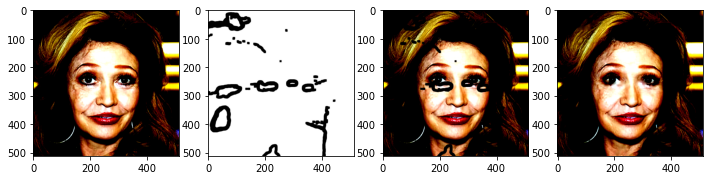

In [51]:
idx = 0
temp_img = imgs[idx].transpose(0, 1).transpose(1, 2).cpu()
temp_mask = masks[idx].transpose(0, 1).transpose(1, 2).cpu()
temp_out = out[idx].transpose(0, 1).transpose(1, 2).cpu().detach().numpy()

f = plt.figure(figsize=(12, 8))
plt.subplot(1, 4, 1)
plt.imshow(temp_img)

plt.subplot(1, 4, 2)
plt.imshow(temp_mask)

plt.subplot(1, 4, 3)
plt.imshow(temp_mask * temp_img)

plt.subplot(1, 4, 4)
plt.imshow(temp_out)
